# Comparison of effects of four anti-cancer drugs on three cancer metrics in mice
## Abstract
Three drug therapies were assessed to determine their efficacies against cancer. A mouse clinical trial was conducted to meaure the effects of these drug therapies on tumour volume, number of metastatic sites, and survival rates. Results indicate that (1) tumours grew bigger for mice treated with Ketapril and Infubinol, as well as the placebo, while tumours shrank in mice treated with Capoulin; (2) the number of metastatic sites increased for mice subjected to all treatments and the placebo, but the rate of increase was slower for mice treated with Capomulin or Infubinol; and (3) the survival rate of Capomulin-treated mice was higher than the survival rates of mice subjected to the other drug therapies. The other drug therapies performed comparatively with the placebo. These results suggest that among the three drug therapies, Capomulin was the most effective treatment for cancer.

## Introduction
Cancer is a cohort of diseases that involves the conversion of normal, healthy cells to tumour cells whose growth cannot be controlled. Because the cells continue growing, they invade surrounding tissues. They eventually spread to other organs in a process called metastatis (WHO 2018). Globally, cancer is a leading cause of death (Torre et al. 2015), which is why finding treatments that could effectively slow down the growth of tumour cells is key to addressing cancer and to prolong a patient's life and to improve his/her quality of life.

An effective pre-clinical trial approach in determining the effectiveness of oncology drug therapies is the "mouse clinical trial" (MCT). This technique presents several advantages (Barbeau 2017); one of them is that MCTs allow for the closest simulation to human clinical trials (Ledford 2012). In this study, therefore, the effectiveness of 10 drug therapies were evaluated using the MCT. 

## Methods
A repeat measures design was used. Mice were randomly assigned to three drug therapies (Capomulin, Infubinol, and Ketapril) and a placebo treatment. Tumour volume, the number of metastatic sites, and the number of surviving mice were determined every five days for 45 days (10 observations). Individual mice were considered as the blocking factor. Results for 100 Mouse ID entries were encoded into two .csv files.

Python (version 3.6) modules Pandas (McKinney 2010), NumPy (Oliphant 2006), and Statsmodels (Seabold & Perktold 2010) were used to process the data. MatPlotLib (https://matplotlib.org/) was used to generate the graphs used to visualise the results.

In [1]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Choose ggplot as style for plots
plt.style.use('ggplot')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

### Raw data

In [3]:
# Load csv
mouse_drug_data_to_load = "mouse_drug_data.csv"
clinical_trial_data_to_load = "clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_df = pd.read_csv(mouse_drug_data_to_load)
trial_df = pd.read_csv(clinical_trial_data_to_load)

# Combine the data into a single dataset (mt = mouse trial)
mt_df = pd.merge(mouse_df, trial_df, on = "Mouse ID")

# Display the data table for preview
mt_df.head()

# select the four drugs for comparison
list_of_drugs = ["Capomulin", "Infubinol", "Ketapril", "Placebo"]
mt_df = mt_df[mt_df["Drug"].isin(list_of_drugs)]
mt_df.head()

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
393,q119,Ketapril,0,45.000000,0
394,q119,Ketapril,5,47.864440,0
395,q119,Ketapril,10,51.236606,0
396,n923,Ketapril,0,45.000000,0
397,n923,Ketapril,5,45.824881,0


### Experiment overview

In [4]:
# list of subjects and treatments
mouse = mt_df["Mouse ID"].unique()
drugs = mt_df["Drug"].unique()
time = mt_df["Timepoint"].unique()

# counts of subjects and treatments
mouse_popn = len(mouse)
no_drugs = len(drugs)
no_measurements = len(time)
no_samples = no_drugs * no_measurements

# summarise in a dataframe
overview = pd.DataFrame({"Number of Mice": mouse_popn,
                         "Number of Drug Treatments": [no_drugs],
                         "Number of Time Measurements": [no_measurements],
                         "Number of Samples": [no_samples]})
overview

,Number of Mice,Number of Drug Treatments,Number of Time Measurements,Number of Samples
0,100,4,10,40


## Results

In [10]:
# Group the data by drug and timepoint
mt_df2 = mt_df.drop("Metastatic Sites", axis = 1)
mt_grped = mt_df2.groupby(["Drug","Timepoint"])

# Get the mean and SEM of tumour volume
tumour_means = pd.DataFrame(mt_grped["Tumor Volume (mm3)"].mean()) # mean for each Drug-Timepoint combination
tumour_sem = pd.DataFrame(mt_grped["Tumor Volume (mm3)"].sem()) # SEM for each Drug-Timepoint combination

# reshape the data
tumour_means = tumour_means.unstack(0)
tumour_sem = tumour_sem.unstack(0)

tumour_means = tumour_means["Tumor Volume (mm3)"]
tumour_sem = tumour_sem["Tumor Volume (mm3)"]

# values for plotting
x_axis = np.arange(0, time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

### Tumour size changes
Results indicated that of the four drug therapies, only Capomulin reduced tumour sizes in mice. At the end of the study, there was a 24% reduction in tumour size for mice assigned to Capomulin. In contrast, the mice subjected to the two drug therapies had more than 30% increase in tumour size, similar to the placebo.

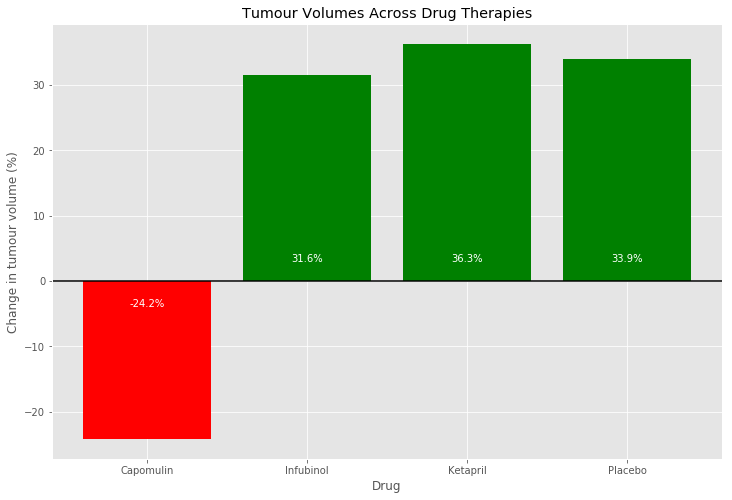

In [15]:
# Filter values to get the data for start and end points of the study
a = tumour_means.iloc[0] # time 00
j = tumour_means.iloc[9] # time 45
xlabels = tumour_means.keys()

# % tumour size change between time 0 and time 45
pct_tumour_change = round((((j - a) / j) * 100),2)
pct_tumour_change

# graph the tumour changes
plt.bar(no_series,
        pct_tumour_change,
        color = ["green" if pct_tumour_change[i] > 0 else "red" for i in no_series])
plt.xticks(no_series, xlabels)
plt.title("Tumour Volumes Across Drug Therapies")
plt.xlabel("Drug")
plt.ylabel("Change in tumour volume (%)")
plt.axhline(y = 0, color = "black")

# Add label inside the bar graph (%)
count = 0

for i in pct_tumour_change:
    if i < 0:
        y = -4
    else:
        y = 3
    plt.text(count, y, str(round(i, 1)) + '%', ha = 'center', color = 'white')
    count += 1

plt.savefig("Images/tumour_v_drug.png")
plt.show()

### Tumor Response Over Time
All therapies studied showed a linear change in tumour volume. The graph shows that tumour volume in Capomulin-treated mice did not happen instantly; tumour size reductions occurred over time. A similar observation was made for the two other drug therapies; however, both of them exhibited behaviour similar to the placebo: there was an increase in tumour volume rather than a decrease.

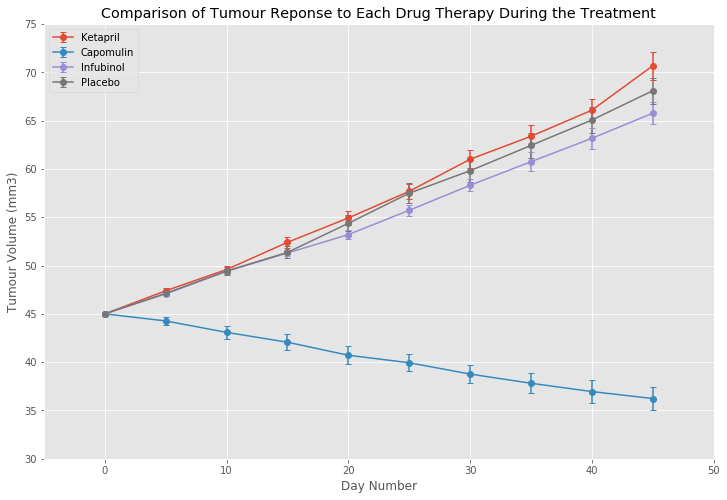

In [7]:
# Plot means and SE

for i in no_series:
    std_error = tumour_sem[drugs[i]]
    plt.errorbar(x_axis, 
                 tumour_means[drugs[i]], 
                 yerr = std_error, 
                 marker = "o", capsize = 3)
    plt.title("Comparison of Tumour Reponse to Each Drug Therapy During the Treatment")
    plt.xlabel("Day Number")
    plt.ylabel("Tumour Volume (mm3)")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(30, 75)
    plt.legend()
    plt.savefig("Images/tumour_v_time.png")

The plots of changes in tumour volumes are not straight lines but the ranges are relatively short. This suggests that there were small variations in the rates of increases or decreases in tumour sizes. The positive values indicate increases in tumour sizes, which was observed for Infubinol, Ketapril, and the placebo. The negative values indicate decreases in tumour sizes, which was observed for Capomulin. 

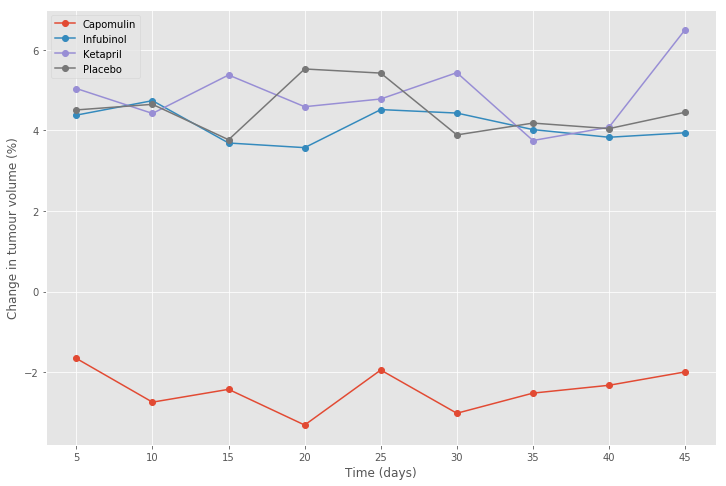

In [8]:
# Data transformation to get %tumour size change
pct_tumour_change = (tumour_means.diff() / tumour_means) * 100

# Prepare plot of tumour change vs time
plt.plot(x_axis,
         pct_tumour_change,
         marker = "o")

plt.xlabel("Time (days)")
plt.ylabel("Change in tumour volume (%)")
plt.legend(tumour_means.keys())
plt.savefig("Images/tumourchange_v_time.png")
plt.show()

### Metastatic Response to Treatment
The number of metastatic sites increased despite the application of drug therapies. At the end of the study, the mice treated with Ketapril had as many metastatic sites as the mice assigned to the placebo treatment. Mice treated with Capomulin or Infubinol were observed to have fewer metastatic sites than the mice treated with the placebo. This suggests that the two drugs were able to slow down the spread of the cancer cells, as compared to the placebo.

In [11]:
mt_df3 = mt_df.drop("Tumor Volume (mm3)", axis = 1)
mt_grped2 = mt_df3.groupby(["Drug","Timepoint"])

In [12]:
# Get the mean and SEM of the number of metastatic sites
meta_means = pd.DataFrame(mt_grped2["Metastatic Sites"].mean()) # mean for each Drug-Timepoint combination
meta_sem = pd.DataFrame(mt_grped2["Metastatic Sites"].sem()) # SEM for each Drug-Timepoint combination

# reshape the data
meta_means = meta_means.unstack(0)
meta_sem = meta_sem.unstack(0)

meta_means = meta_means["Metastatic Sites"]
meta_sem = meta_sem["Metastatic Sites"]

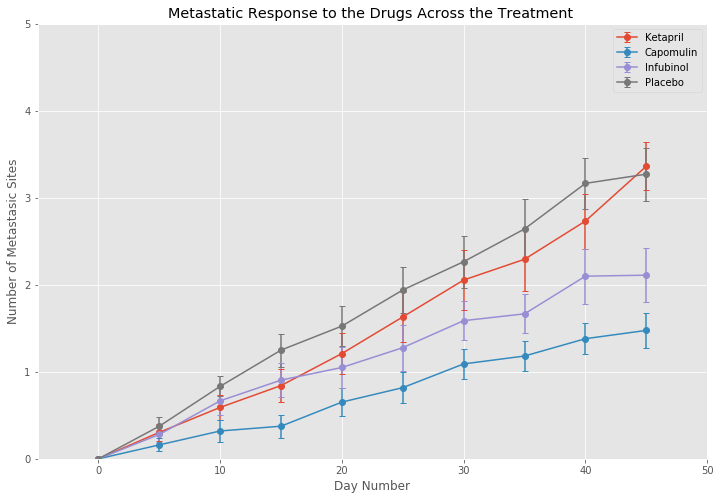

In [13]:
# Plot means and SE

x_axis = np.arange(0,time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    std_error = meta_sem[drugs[i]]
    plt.errorbar(x_axis, 
                 meta_means[drugs[i]], 
                 yerr = std_error, 
                 marker = "o", capsize = 3)
    plt.title("Metastatic Response to the Drugs Across the Treatment ")
    plt.xlabel("Day Number")
    plt.ylabel("Number of Metastasic Sites")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(0, 5)
    plt.legend()
    plt.savefig("Images/meta_v_time.png")

### Survival Rates
Each drug treatment started with 25 mice. At the end of the study, four Capomulin-treated mice died. Infubinol had the highest number of mouse deaths, at 16. Ketapril and the placebo had 14 mouse deaths, apiece.

In [12]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
no_mice = mt_grped["Mouse ID"].count()
no_mice = pd.DataFrame(no_mice.unstack(0))
no_mice

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,25,25,25,25
5,25,25,23,24
10,25,21,22,24
15,24,21,19,20
20,23,20,19,19
25,22,18,19,17
30,22,17,18,15
35,22,12,17,14
40,21,10,15,12


Moreover, the plots show that the deaths started as soon as five days after the treatments started for mice assigned to Ketapril and to the placebo; the decline appeared to be relatively steady. The Capomulin treatment did not have any deaths until the tenth day. In contrast, most of the deaths for the Infunibol-treated mice occurred between Days 5 and 10 and Days 30 and 35. 

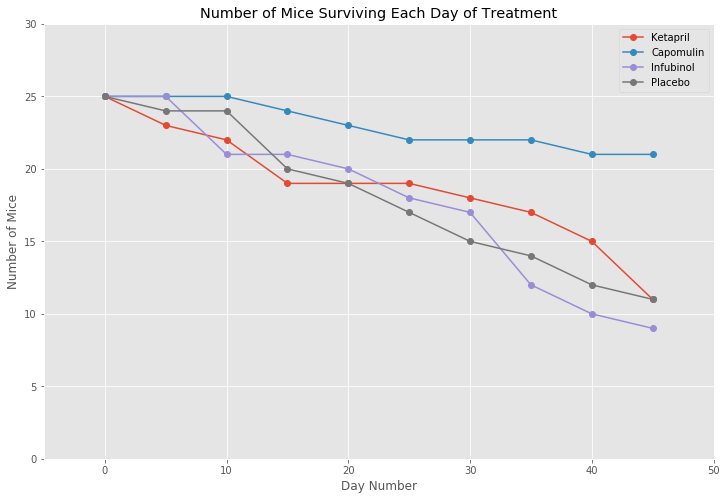

In [13]:
# Plot number of surviving mice per unit time

x_axis = np.arange(0,time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    plt.plot(x_axis, 
             no_mice[drugs[i]], 
             marker = "o")
    plt.title("Number of Mice Surviving Each Day of Treatment")
    plt.xlabel("Day Number")
    plt.ylabel("Number of Mice")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(0, 30)
    plt.legend()
    plt.savefig("Images/mice_v_time.png")

Following Nohrmann's (1953) for calculating for survival rate, a similar graph was obtained. It was noted that on this graph, it showed that the placebo-treated mice had a slightly better survival rate than the Ketapril-treated mice.

In [14]:
# Mouse mortality values
mortality = (abs(no_mice.diff()) / no_mice)
mortality["time"] = time
mortality

# survival = 1 - mouse mortality
def survive(x): # where x is the index of time (range: time[1] = 5 to time[9] = 45)
    return 1 - mortality.iloc[x,0:4]

surv_t05 = survive(1)
surv_t10 = survive(2)
surv_t15 = survive(3)
surv_t20 = survive(4)
surv_t25 = survive(5)
surv_t30 = survive(6)
surv_t35 = survive(7)
surv_t40 = survive(8)
surv_t45 = survive(9)

# survival rate per year
survival_rate_t05 = 100 * surv_t05
survival_rate_t10 = 100 * surv_t05 * surv_t10
survival_rate_t15 = 100 * surv_t05 * surv_t10 * surv_t15
survival_rate_t20 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20
survival_rate_t25 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25
survival_rate_t30 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25 * surv_t30
survival_rate_t35 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25 * surv_t30 * surv_t35
survival_rate_t40 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25 * surv_t30 * surv_t35 * surv_t40
survival_rate_t45 = 100 * surv_t05 * surv_t10 * surv_t15 * surv_t20 \
                        * surv_t25 * surv_t30 * surv_t35 * surv_t40 \
                        * surv_t45

survival_rates = pd.DataFrame(dict(survival_rate_t05 = survival_rate_t05,
                                   survival_rate_t10 = survival_rate_t10,
                                   survival_rate_t15 = survival_rate_t15,
                                   survival_rate_t20 = survival_rate_t20,
                                   survival_rate_t25 = survival_rate_t25,
                                   survival_rate_t30 = survival_rate_t30,
                                   survival_rate_t35 = survival_rate_t35,
                                   survival_rate_t40 = survival_rate_t40,
                                   survival_rate_t45 = survival_rate_t45))
survival_rates = survival_rates.rename(columns = {"survival_rate_t05": "t05",
                                                  "survival_rate_t10": "t10",
                                                  "survival_rate_t15": "t15",
                                                  "survival_rate_t20": "t20",
                                                  "survival_rate_t25": "t25",
                                                  "survival_rate_t30": "t30",
                                                  "survival_rate_t35": "t35",
                                                  "survival_rate_t40": "t40",
                                                  "survival_rate_t45": "t45"})
sr1 = survival_rates.transpose() # use the drug names as the keys in the dataframe
sr1

Drug,Capomulin,Infubinol,Ketapril,Placebo
t05,100.000000,100.000000,91.304348,95.833333
t10,100.000000,80.952381,87.154150,95.833333
t15,95.833333,80.952381,73.392969,76.666667
t20,91.666667,76.904762,73.392969,72.631579
t25,87.500000,68.359788,73.392969,64.086687
t30,87.500000,64.338624,69.315581,55.541796
t35,87.500000,37.530864,65.238194,51.574525
t40,83.333333,30.024691,56.539768,42.978770
t45,83.333333,26.688615,35.979853,39.071610


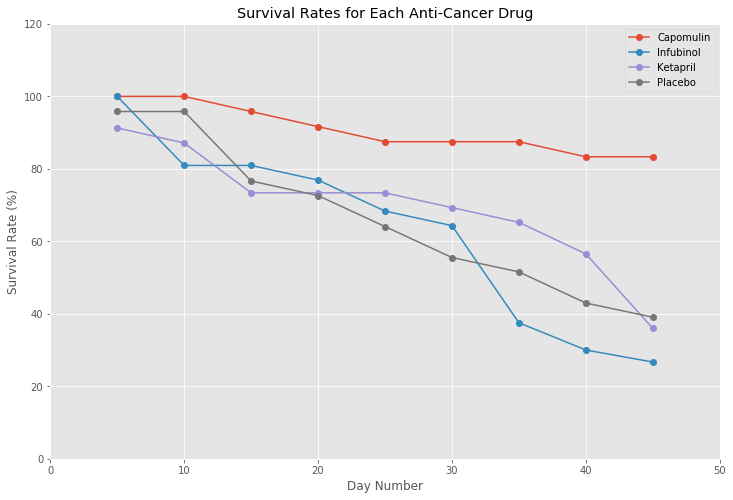

In [15]:
# Plot survival rates

plt.plot(np.delete(time, 0), 
        sr1, 
        marker = "o")
plt.title("Survival Rates for Each Anti-Cancer Drug")
plt.xlabel("Day Number")
plt.ylabel("Survival Rate (%)")
plt.xlim(0, max(time) + 5)
plt.ylim(0, 120)
plt.legend(sr1.keys())
plt.savefig("Images/pct_mice_v_time.png")

## Conclusions
The study indicated that based on tumour volume reductions, number of metastatic sites, and survival rates in the test subjects, Capomulin appeared to be the most effective medicine for the treatment of cancer. On the other hand, the three other therapies performed comparably with the placebo, suggesting that these using these drug therapies was no better than not receiving treatment for cancer in the test subjects.

## References
Barbeau, J. 2017. [Top five reasons to use mouse clinical trials](https://blog.crownbio.com/top-5-reasons-mouse-clinical-trials).

Ledford, H. 2012. [Mice guide human drug trial](https://www.nature.com/polopoly_fs/1.10256!/menu/main/topColumns/topLeftColumn/pdf/483389a.pdf?origin=ppub) Nature 483: 389.

McKinney, W. 2010. [Data structures of statistical computing in Python](http://conference.scipy.org/proceedings/scipy2010/pdfs/mckinney.pdf). Proceedings of the 9th Python in Science Conference. pp. 51–56.

Nohrmann, B. A. 1953. [Survival rate calculation](https://www.tandfonline.com/doi/pdf/10.3109/00016925309136688). Acta Radiologica. 39(1): 78–82.

Oliphant, T. E. 2006. A Guide to NumPy. USA: Trelgol Publishing. 

Seabold, Skipper, and Josef Perktold. 2010. “Statsmodels: Econometric and statistical modeling with python.” Proceedings of the 9th Python in Science Conference. 

Torre, L. A., F. Bray, R. L. Siegel, J. Ferlay, J. Lorlet-Tieulent, A. Jemal. 2015. [Global cancer statistics 2012](https://doi.org/10.3322/caac.21262). CA: A Cancer Journal for Clinicians 65(2): 87–108.

World Health Organisation. 2018. [Cancer Fact Sheet No. 297](http://www.who.int/en/news-room/fact-sheets/detail/cancer)